[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from numpy.random import seed
seed(99)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print("Tensorflow Version:", tf.__version__, "Keras Verion:", keras.__version__)
print("The current work path: ", os.getcwd())

Using TensorFlow backend.


Tensorflow Version: 2.1.0 Keras Verion: 2.2.4
The current work path:  D:\Code\skin-cancer-detection


In [3]:
base_dir = 'base_dir'
os.listdir(base_dir)

['test_dir', 'train_dir']

In [4]:
# check how many train images we have in each folder
print("nv: {}".format(len(os.listdir(base_dir + '/train_dir/nv'))))
print("mel: {}".format(len(os.listdir(base_dir + '/train_dir/mel'))))
print("bkl: {}".format(len(os.listdir(base_dir + '/train_dir/bkl'))))
print("bcc: {}".format(len(os.listdir(base_dir + '/train_dir/bcc'))))
print("akiec: {}".format(len(os.listdir(base_dir + '/train_dir/akiec'))))
print("vasc: {}".format(len(os.listdir(base_dir + '/train_dir/vasc'))))
print("df: {}".format(len(os.listdir(base_dir + '/train_dir/df'))))

nv: 5380
mel: 1044
bkl: 967
bcc: 461
akiec: 282
vasc: 123
df: 103


In [5]:
# check how many test images we have in each folder
print("nv: {}".format(len(os.listdir(base_dir + '/test_dir/nv'))))
print("mel: {}".format(len(os.listdir(base_dir + '/test_dir/mel'))))
print("bkl: {}".format(len(os.listdir(base_dir + '/test_dir/bkl'))))
print("bcc: {}".format(len(os.listdir(base_dir + '/test_dir/bcc'))))
print("akiec: {}".format(len(os.listdir(base_dir + '/test_dir/akiec'))))
print("vasc: {}".format(len(os.listdir(base_dir + '/test_dir/vasc'))))
print("df: {}".format(len(os.listdir(base_dir + '/test_dir/df'))))

nv: 1325
mel: 69
bkl: 132
bcc: 53
akiec: 45
vasc: 19
df: 12


In [6]:
test_path = base_dir + "/test_dir"
train_path = base_dir + "/train_dir"

In [7]:
num_train_samples = 5308+1044+967+461+282+123+103
num_test_samples = 1325+69+132+53+45+19+12
train_batch_size = 10
test_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [8]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input)
# Do not augment the test set
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=test_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 8360 images belonging to 7 classes.
Found 1655 images belonging to 7 classes.
Found 1655 images belonging to 7 classes.


# MobileNet

In [9]:
# create a copy of a mobilenet model
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [10]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [11]:
# How many layers does MobileNet have?
display(type(mobile.layers), len(mobile.layers))

list

93

In [12]:
# CREATE THE MODEL ARCHITECTURE
# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the dense layer we created above.
model = Model(inputs=mobile.input, outputs=predictions)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [14]:
# We need to choose how many layers we actually want to be trained.
# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.
for layer in model.layers[:-23]:
    layer.trainable = False

Train the Model:

In [15]:
# Define Top2 and Top3 Accuracy
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [16]:
model.compile(Adam(lr=0.01), 
              loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [17]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [18]:
# Add weights to try to make the model more sensitive to melanoma
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [19]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', 
                              factor=0.5, 
                              patience=2, 
                              verbose=1, 
                              mode='max',
                              min_lr=0.00001)
      
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, 
                              steps_per_epoch=train_steps, 
                              class_weight=class_weights, 
                              validation_data=valid_batches,
                              validation_steps=test_steps,
                              epochs=30, 
                              verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 829.0 steps, validate for 166.0 steps
Epoch 1/30
828/829 [============================>.] - ETA: 0s - loss: 1.5126 - categorical_accuracy: 0.5969 - top_2_accuracy: 0.7957 - top_3_accuracy: 0.8946
Epoch 00001: val_top_3_accuracy improved from -inf to 0.89849, saving model to model.h5
829/829 [==============================] - 688s 830ms/step - loss: 1.5119 - categorical_accuracy: 0.5969 - top_2_accuracy: 0.7957 - top_3_accuracy: 0.8947 - val_loss: 1.1981 - val_categorical_accuracy: 0.5366 - val_top_2_accuracy: 0.8326 - val_top_3_accuracy: 0.8985
Epoch 2/30
828/829 [============================>.] - ETA: 0s - loss: 1.1745 - categorical_accuracy: 0.6393 - top_2_accuracy: 0.8364 - top_3_accuracy: 0.9222
Epoch 00002: val_top_3_accuracy improved from 0.89849 to 0.93716, saving model to model.h5
829/829 [==============================] - 675s 814ms/step - los

Epoch 16/30
828/829 [============================>.] - ETA: 0s - loss: 0.5648 - categorical_accuracy: 0.8272 - top_2_accuracy: 0.9499 - top_3_accuracy: 0.9844
Epoch 00016: val_top_3_accuracy did not improve from 0.95589

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
829/829 [==============================] - 682s 822ms/step - loss: 0.5642 - categorical_accuracy: 0.8274 - top_2_accuracy: 0.9499 - top_3_accuracy: 0.9844 - val_loss: 0.9991 - val_categorical_accuracy: 0.8060 - val_top_2_accuracy: 0.8888 - val_top_3_accuracy: 0.9360
Epoch 17/30
828/829 [============================>.] - ETA: 0s - loss: 0.5567 - categorical_accuracy: 0.8333 - top_2_accuracy: 0.9482 - top_3_accuracy: 0.9859
Epoch 00017: val_top_3_accuracy did not improve from 0.95589
829/829 [==============================] - 683s 823ms/step - loss: 0.5573 - categorical_accuracy: 0.8331 - top_2_accuracy: 0.9481 - top_3_accuracy: 0.9859 - val_loss: 0.9894 - val_categorical_accuracy: 0.8085 - 

In [20]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [21]:
# Here the the last epoch will be used.
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = model.evaluate_generator(test_batches, 
                                                                               steps=1325+69+132+53+45+19+12)
print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
val_loss: 0.892427381276812
val_cat_acc: 0.8060423
val_top_2_acc: 0.8918429
val_top_3_acc: 0.93232626


In [22]:
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, steps=1325+69+132+53+45+19+12, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
1655/1655 [==============================] - 48s 29ms/step


In [23]:
confusionMatrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
print("The confustion matrix:\n", confusionMatrix)
print("The accuracy is: ", sum(np.diag(confusionMatrix))/confusionMatrix.sum())

The confustion matrix:
 [[   6    2    1    2   30    3    1]
 [   2    8    0    0   28   15    0]
 [   2    0    9    2   52   67    0]
 [   0    0    0    1    1   10    0]
 [   1    0    0    1   33   34    0]
 [   0    0    1    6   57 1261    0]
 [   0    0    0    0    1   11    7]]
The accuracy is:  0.8006042296072508


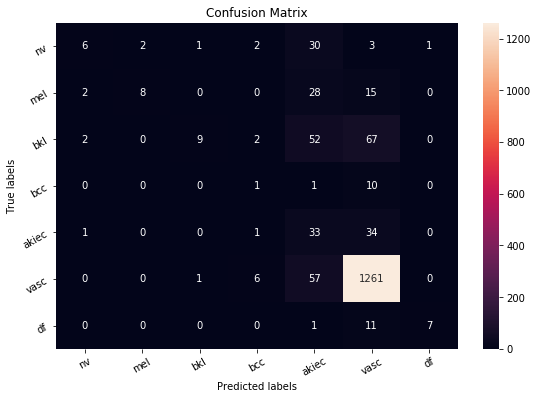

In [24]:
names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

fig, axes = plt.subplots(figsize=(9, 6))
sns.heatmap(confusionMatrix, annot = True, ax = axes, fmt = 'g')

# labels, title and ticks
axes.set_xlabel('Predicted labels')
axes.set_ylabel('True labels')
axes.set_title('Confusion Matrix')
axes.xaxis.set_ticklabels(names, rotation=30)
axes.yaxis.set_ticklabels(names, rotation=30)
plt.show()

In [25]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)
# Get the labels of the test images.
y_true = test_batches.classes
# Generate a classification report
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.55      0.13      0.21        45
         bcc       0.80      0.15      0.25        53
         bkl       0.82      0.07      0.13       132
          df       0.08      0.08      0.08        12
         mel       0.16      0.48      0.24        69
          nv       0.90      0.95      0.93      1325
        vasc       0.88      0.37      0.52        19

    accuracy                           0.80      1655
   macro avg       0.60      0.32      0.34      1655
weighted avg       0.84      0.80      0.78      1655



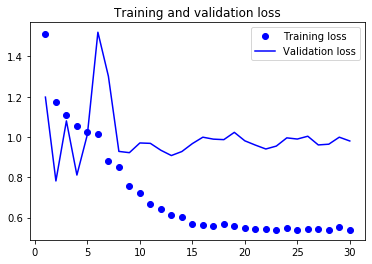

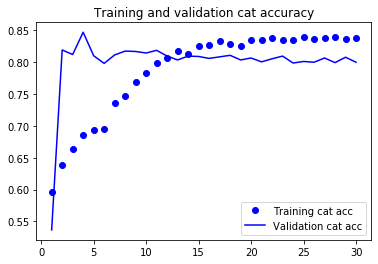

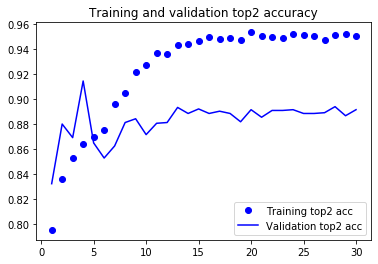

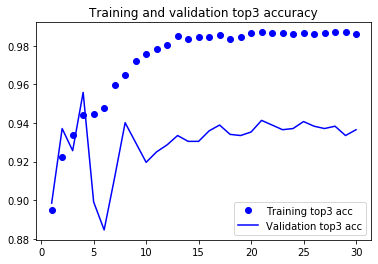

In [26]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()
plt.show()